# Testing on predicting casual and Register

In [21]:
import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, StackingRegressor
from xgboost import XGBRegressor, plot_importance
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, MinMaxScaler, RobustScaler, OneHotEncoder
from sklearn.metrics import r2_score
import pickle

import plotly.express as px

In [2]:
df = pd.read_csv("../Datas/data.csv")

In [5]:
df_casual_register = pd.read_csv("../Datas/train.csv")

In [6]:
df_casual_register.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [7]:
df_casual_register['month'] = df['month']
df_casual_register['year'] = df['year']
df_casual_register.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,month,year
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,1,2011
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1,2011
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,1,2011
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,1,2011
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,1,2011


In [42]:
y_train_casual = np.log1p(df_casual_register[(df_casual_register.month <=  8) | (df_casual_register.year == 2011)]["casual"])
y_train_registered = np.log1p(df_casual_register[(df_casual_register.month <=  8) | (df_casual_register.year == 2011)]["registered"])

y_test_casual = np.log1p(df_casual_register[(df_casual_register.month >  8) & (df_casual_register.year == 2012)]["casual"])
y_test_registered = np.log1p(df_casual_register[(df_casual_register.month >  8) & (df_casual_register.year == 2012)]["registered"])

In [3]:
X_train = df[(df.month <=  8) | (df.year == 2011)].drop(["datetime", "weather","count"], axis=1)
X_test = df[(df.month >  8) & (df.year == 2012)].drop(["datetime", "weather","count"], axis=1)
y_train = np.log1p(df[(df.month <=  8) | (df.year == 2011)]["count"])
y_test = np.log1p(df[(df.month >  8) & (df.year == 2012)]["count"])

In [9]:
df_final_X = df.drop(["datetime", "weather","count"], axis=1)
df_final_y = np.log1p(df["count"])

df_final_y_casual = np.log1p(df_casual_register["casual"])
df_final_y_registered = np.log1p(df_casual_register["registered"])


In [10]:
one_hot_features = ["holiday", "workingday", "season", "month", "day", "year"]
standard_feature = ["temp", "humidity", "windspeed", "day_number", "hour"]

one_hot_pipeline = make_pipeline(OneHotEncoder(handle_unknown="ignore"))
standard_pipeline = make_pipeline(StandardScaler())

processor = make_column_transformer((one_hot_pipeline, one_hot_features), (standard_pipeline, standard_feature))

In [ ]:
rfr = make_pipeline(processor, RandomForestRegressor(random_state=1))
etr = make_pipeline(processor, ExtraTreesRegressor(random_state=1))
lgbm = make_pipeline(processor, LGBMRegressor(random_state=1))
xgbr = make_pipeline(processor, XGBRegressor(random_state=1))

## Casual

In [13]:
# compare machine learning models for regression
from numpy import mean
from numpy import std
from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from matplotlib import pyplot


# get a list of models to evaluate
def get_models():
    models = dict()
    models['rfr'] = make_pipeline(processor, RandomForestRegressor(random_state=1))
    models['etr'] = make_pipeline(processor, ExtraTreesRegressor(random_state=1))
    models['lgbm'] = make_pipeline(processor, LGBMRegressor(random_state=1))
    models['xgbr'] = make_pipeline(processor, XGBRegressor(random_state=1))
    
    return models

# evaluate a given model using cross-validation
def evaluate_model(model, X_train, y_train_casual, X_test, y_test_casual):
	
	model.fit(X_train, y_train_casual)
	scores = model.score(X_test, y_test_casual)

	return scores

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
print ('####################################')
print ('##     Prediction for Casual      ##')
print ('####################################')
for name, model in models.items():
	scores = evaluate_model(model,X_train, y_train_casual, X_test, y_test_casual)
	results.append(scores)
	names.append(name)
	print('>%s %.3f' % (name, mean(scores)))


####################################
##     Prediction for Casual      ##
####################################
>rfr 0.830
>etr 0.854
>lgbm 0.865
>xgbr 0.842


## Registered

In [14]:
# compare machine learning models for regression
from numpy import mean
from numpy import std
from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from matplotlib import pyplot


# get a list of models to evaluate
def get_models():
    models = dict()
    models['rfr'] = make_pipeline(processor, RandomForestRegressor(random_state=1))
    models['etr'] = make_pipeline(processor, ExtraTreesRegressor(random_state=1))
    models['lgbm'] = make_pipeline(processor, LGBMRegressor(random_state=1))
    models['xgbr'] = make_pipeline(processor, XGBRegressor(random_state=1))
    
    return models

# evaluate a given model using cross-validation
def evaluate_model(model, X_train, y_train_registered, X_test, y_test_registered):
	
	model.fit(X_train, y_train_registered)
	scores = model.score(X_test, y_test_registered)

	return scores

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
print ('####################################')
print ('##     Prediction for Registered      ##')
print ('####################################')
for name, model in models.items():
	scores = evaluate_model(model,X_train, y_train_registered, X_test, y_test_registered)
	results.append(scores)
	names.append(name)
	print('>%s %.3f' % (name, mean(scores)))


####################################
##     Prediction for Registered      ##
####################################
>rfr 0.901
>etr 0.935
>lgbm 0.910
>xgbr 0.901


In [16]:
models

{'rfr': Pipeline(steps=[('columntransformer',
                  ColumnTransformer(transformers=[('pipeline-1',
                                                   Pipeline(steps=[('onehotencoder',
                                                                    OneHotEncoder(handle_unknown='ignore'))]),
                                                   ['holiday', 'workingday',
                                                    'season', 'month', 'day',
                                                    'year']),
                                                  ('pipeline-2',
                                                   Pipeline(steps=[('standardscaler',
                                                                    StandardScaler())]),
                                                   ['temp', 'humidity',
                                                    'windspeed', 'day_number',
                                                    'hour'])])),
                 ('r

## Create Models for Casual and Registered

In [18]:

models_etr_casual = make_pipeline(processor, ExtraTreesRegressor(random_state=1))
models_lgbm_casual = make_pipeline(processor, LGBMRegressor(random_state=1))
models_xgbr_casual = make_pipeline(processor, XGBRegressor(random_state=1))

models_etr_registered = make_pipeline(processor, ExtraTreesRegressor(random_state=1))
models_lgbm_registered = make_pipeline(processor, LGBMRegressor(random_state=1))
models_xgbr_registered = make_pipeline(processor, XGBRegressor(random_state=1))


In [19]:

models_etr_casual.fit(df_final_X, df_final_y_casual)
models_lgbm_casual.fit(df_final_X, df_final_y_casual)
models_xgbr_casual.fit(df_final_X, df_final_y_casual)

models_etr_registered.fit(df_final_X, df_final_y_registered)
models_lgbm_registered.fit(df_final_X, df_final_y_registered)
models_xgbr_registered.fit(df_final_X, df_final_y_registered)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['holiday', 'workingday',
                                                   'season', 'month', 'day',
                                                   'year']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  ['temp', 'humidity',
                                                   'windspeed', 'day_number',
                                                   'hour'])])),
                ('xgbregress...
        

In [20]:
# pickle.dump(models_etr_casual, open('models_etr_casual.sav', 'wb'))
# pickle.dump(models_lgbm_casual, open('models_lgbm_casual.sav', 'wb'))
# pickle.dump(models_xgbr_casual, open('models_xgbr_casual.sav', 'wb'))

# pickle.dump(models_etr_registered, open('models_etr_registered.sav', 'wb'))
# pickle.dump(models_lgbm_registered, open('models_lgbm_registered.sav', 'wb'))
# pickle.dump(models_xgbr_registered, open('models_xgbr_registered.sav', 'wb'))


## Stacking Linear SVR for lightGBM + XGBoost

In [27]:
# define the base models
level0_stack_LinearSVR_lgbm_xgboost = list()

level0_stack_LinearSVR_lgbm_xgboost.append(('lgbm', make_pipeline(processor, LGBMRegressor(random_state=1))))
level0_stack_LinearSVR_lgbm_xgboost.append(('xgbr', make_pipeline(processor, XGBRegressor(random_state=1))))

from sklearn.svm import LinearSVR

# define meta learner model
level1 = LinearSVR()

# define the stacking ensemble

model_stack_LinearSVR_lgbm_xgboost_casual = StackingRegressor(estimators=level0_stack_LinearSVR_lgbm_xgboost, final_estimator=level1)
model_stack_LinearSVR_lgbm_xgboost_registered = StackingRegressor(estimators=level0_stack_LinearSVR_lgbm_xgboost, final_estimator=level1)

# fit the model on all available data
model_stack_LinearSVR_lgbm_xgboost_casual.fit(X_train, y_train_casual)
model_stack_LinearSVR_lgbm_xgboost_registered.fit(X_train, y_train_registered)

# Get score for each models
score_stack_LinearSVR_lgbm_xgboost_casual = model_stack_LinearSVR_lgbm_xgboost_casual.score(X_test, y_test_casual)
score_stack_LinearSVR_lgbm_xgboost_registered = model_stack_LinearSVR_lgbm_xgboost_registered.score(X_test, y_test_registered)

# print all scores
print('R2 score for LBGM + XGB (LinearSVR)-casual: %.3f' % (score_stack_LinearSVR_lgbm_xgboost_casual))
print('R2 score for LBGM + XGB (LinearSVR)-registered: %.3f' % (score_stack_LinearSVR_lgbm_xgboost_registered))


C:\Users\Apprenant\anaconda3\envs\candiapp\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


R2 score for LBGM + XGB (LinearSVR)-casual: 0.860
R2 score for LBGM + XGB (LinearSVR)-registered: 0.927


C:\Users\Apprenant\anaconda3\envs\candiapp\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [29]:
models_rfr_casual = make_pipeline(processor, RandomForestRegressor(random_state=1))
models_etr_casual = make_pipeline(processor, ExtraTreesRegressor(random_state=1))
models_lgbm_casual = make_pipeline(processor, LGBMRegressor(random_state=1))
models_xgbr_casual = make_pipeline(processor, XGBRegressor(random_state=1))

models_rfr_registered = make_pipeline(processor, RandomForestRegressor(random_state=1))
models_etr_registered = make_pipeline(processor, ExtraTreesRegressor(random_state=1))
models_lgbm_registered = make_pipeline(processor, LGBMRegressor(random_state=1))
models_xgbr_registered = make_pipeline(processor, XGBRegressor(random_state=1))

In [30]:
models_rfr_casual.fit(df_final_X, df_final_y_casual)
models_etr_casual.fit(df_final_X, df_final_y_casual)
models_lgbm_casual.fit(df_final_X, df_final_y_casual)
models_xgbr_casual.fit(df_final_X, df_final_y_casual)

models_rfr_registered.fit(df_final_X, df_final_y_registered)
models_etr_registered.fit(df_final_X, df_final_y_registered)
models_lgbm_registered.fit(df_final_X, df_final_y_registered)
models_xgbr_registered.fit(df_final_X, df_final_y_registered)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['holiday', 'workingday',
                                                   'season', 'month', 'day',
                                                   'year']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  ['temp', 'humidity',
                                                   'windspeed', 'day_number',
                                                   'hour'])])),
                ('xgbregress...
        

In [28]:
model_stack_LinearSVR_lgbm_xgboost_casual.fit(df_final_X, df_final_y_casual)
model_stack_LinearSVR_lgbm_xgboost_registered.fit(df_final_X, df_final_y_registered)

C:\Users\Apprenant\anaconda3\envs\candiapp\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Apprenant\anaconda3\envs\candiapp\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


StackingRegressor(estimators=[('lgbm',
                               Pipeline(steps=[('columntransformer',
                                                ColumnTransformer(transformers=[('pipeline-1',
                                                                                 Pipeline(steps=[('onehotencoder',
                                                                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                                                                 ['holiday',
                                                                                  'workingday',
                                                                                  'season',
                                                                                  'month',
                                                                                  'day',
                                                                                

In [31]:
models_rfr_casual.fit(X_train, y_train_casual)
y_pred_rfr_casual = models_rfr_casual.predict(X_test)
score_rfr_casual = models_rfr_casual.score(X_test, y_test_casual)

models_etr_casual.fit(X_train, y_train_casual)
y_pred_etr_casual = models_etr_casual.predict(X_test)
score_etr_casual = models_etr_casual.score(X_test, y_test_casual)

models_xgbr_casual.fit(X_train, y_train_casual)
y_pred_xgbr_casual = models_xgbr_casual.predict(X_test)
score_xgbr_casual = models_xgbr_casual.score(X_test, y_test_casual)


models_lgbm_casual.fit(X_train, y_train_casual)
y_pred_lgbm_casual = models_lgbm_casual.predict(X_test)
score_lgbm_casual = models_lgbm_casual.score(X_test, y_test_casual)

model_stack_LinearSVR_lgbm_xgboost_casual.fit(X_train, y_train_casual)
y_pred_stack_LinearSVR_lgbm_xgboost_casual = model_stack_LinearSVR_lgbm_xgboost_casual.predict(X_test)
score_stack_LinearSVR_lgbm_xgboost_casual = model_stack_LinearSVR_lgbm_xgboost_casual.score(X_test, y_test_casual)



C:\Users\Apprenant\anaconda3\envs\candiapp\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [33]:
plot_model_casual = pd.DataFrame(data=y_test, columns=['y_test_casual'])
# plot_y_etr['y_test'] = y_test
plot_model_casual['y_test_casual']=y_test_casual
plot_model_casual['y_pred_etr_casual']=y_pred_etr_casual
plot_model_casual['y_pred_rfr_casual']=y_pred_rfr_casual
plot_model_casual['y_pred_xgbr_casual']=y_pred_xgbr_casual
plot_model_casual['y_pred_lgbm_casual']=y_pred_lgbm_casual
plot_model_casual['y_pred_stack_LinearSVR_lgbm_xgboost_casual']=y_pred_stack_LinearSVR_lgbm_xgboost_casual
plot_model_casual


,y_test_casual,y_pred_etr_casual,y_pred_rfr_casual,y_pred_xgbr_casual,y_pred_lgbm_casual,y_pred_stack_LinearSVR_lgbm_xgboost_casual
9063,3.135494,3.402973,3.116871,3.428873,3.203337,3.223435
9064,2.484907,3.109004,2.878488,3.142870,2.923778,2.934948
9065,2.197225,2.800714,2.640482,3.064735,2.665402,2.697532
9066,1.945910,2.647095,2.369549,2.402518,2.085681,2.088453
9067,1.386294,1.199351,1.126038,1.322259,1.244943,1.186332
...,...,...,...,...,...,...
10881,2.079442,2.684971,2.606773,2.736001,2.729314,2.701656
10882,2.397895,2.631964,2.547146,2.539891,2.488093,2.460682
10883,1.609438,2.293680,2.251630,2.231329,2.054761,2.034652
10884,2.564949,1.953341,1.954555,2.129404,1.966864,1.942066


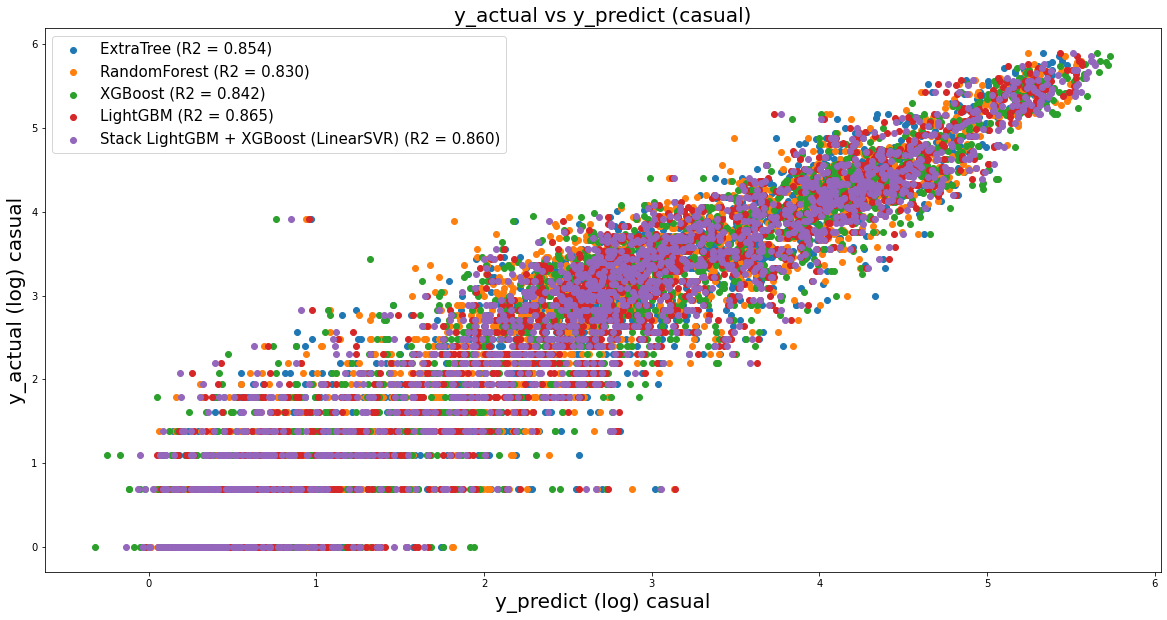

In [37]:
plt.rcParams["figure.figsize"] = (20,10)

plt.scatter(plot_model_casual['y_pred_etr_casual'], plot_model_casual['y_test_casual'],label="ExtraTree (R2 = %0.3f)" % score_etr_casual)
plt.scatter(plot_model_casual['y_pred_rfr_casual'], plot_model_casual['y_test_casual'],label="RandomForest (R2 = %0.3f)" % score_rfr_casual)
plt.scatter(plot_model_casual['y_pred_xgbr_casual'], plot_model_casual['y_test_casual'],label="XGBoost (R2 = %0.3f)" % score_xgbr_casual)
plt.scatter(plot_model_casual['y_pred_lgbm_casual'], plot_model_casual['y_test_casual'],label="LightGBM (R2 = %0.3f)" % score_lgbm_casual)
plt.scatter(plot_model_casual['y_pred_stack_LinearSVR_lgbm_xgboost_casual'], plot_model_casual['y_test_casual'],label="Stack LightGBM + XGBoost (LinearSVR) (R2 = %0.3f)" % score_stack_LinearSVR_lgbm_xgboost_casual)
plt.title('y_actual vs y_predict (casual)', fontsize=20)
plt.xlabel('y_predict (log) casual', fontsize=20)
plt.ylabel('y_actual (log) casual', fontsize=20)
plt.legend(fontsize=15)

In [38]:
models_rfr_registered.fit(X_train, y_train_registered)
y_pred_rfr_registered = models_rfr_registered.predict(X_test)
score_rfr_registered = models_rfr_registered.score(X_test, y_test_registered)

models_etr_registered.fit(X_train, y_train_registered)
y_pred_etr_registered = models_etr_registered.predict(X_test)
score_etr_registered = models_etr_registered.score(X_test, y_test_registered)

models_xgbr_registered.fit(X_train, y_train_registered)
y_pred_xgbr_registered = models_xgbr_registered.predict(X_test)
score_xgbr_registered = models_xgbr_registered.score(X_test, y_test_registered)


models_lgbm_registered.fit(X_train, y_train_registered)
y_pred_lgbm_registered = models_lgbm_registered.predict(X_test)
score_lgbm_registered = models_lgbm_registered.score(X_test, y_test_registered)

model_stack_LinearSVR_lgbm_xgboost_registered.fit(X_train, y_train_registered)
y_pred_stack_LinearSVR_lgbm_xgboost_registered = model_stack_LinearSVR_lgbm_xgboost_registered.predict(X_test)
score_stack_LinearSVR_lgbm_xgboost_registered = model_stack_LinearSVR_lgbm_xgboost_registered.score(X_test, y_test_registered)



C:\Users\Apprenant\anaconda3\envs\candiapp\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [46]:
plot_model_registered = pd.DataFrame(data=y_test, columns=['y_test_registered'])
# plot_y_etr['y_test'] = y_test
plot_model_registered['y_test_registered']= y_test_registered
plot_model_registered['y_pred_etr_registered']=y_pred_etr_registered
plot_model_registered['y_pred_rfr_registered']=y_pred_rfr_registered
plot_model_registered['y_pred_xgbr_registered']=y_pred_xgbr_registered
plot_model_registered['y_pred_lgbm_registered']=y_pred_lgbm_registered
plot_model_registered['y_pred_stack_LinearSVR_lgbm_xgboost_registered']=y_pred_stack_LinearSVR_lgbm_xgboost_registered
plot_model_registered


,y_test_registered,y_pred_etr_registered,y_pred_rfr_registered,y_pred_xgbr_registered,y_pred_lgbm_registered,y_pred_stack_LinearSVR_lgbm_xgboost_registered
9063,4.990433,4.876632,4.849935,4.706543,4.773587,4.893616
9064,4.234107,4.467676,4.410493,4.353787,4.525310,4.648463
9065,4.127134,4.022846,4.037726,3.978717,4.046749,4.149225
9066,3.401197,3.065154,3.121030,3.429197,3.250888,3.312474
9067,2.302585,2.291051,2.069289,2.151500,2.279253,2.344063
...,...,...,...,...,...,...
10881,5.799093,5.790605,5.745438,5.842773,5.666563,5.786958
10882,5.446737,5.362074,5.297961,5.487851,5.350341,5.466452
10883,5.105945,5.237866,4.924492,5.076448,4.938992,5.045124
10884,4.770685,5.003404,4.646875,5.017843,4.706041,4.791251


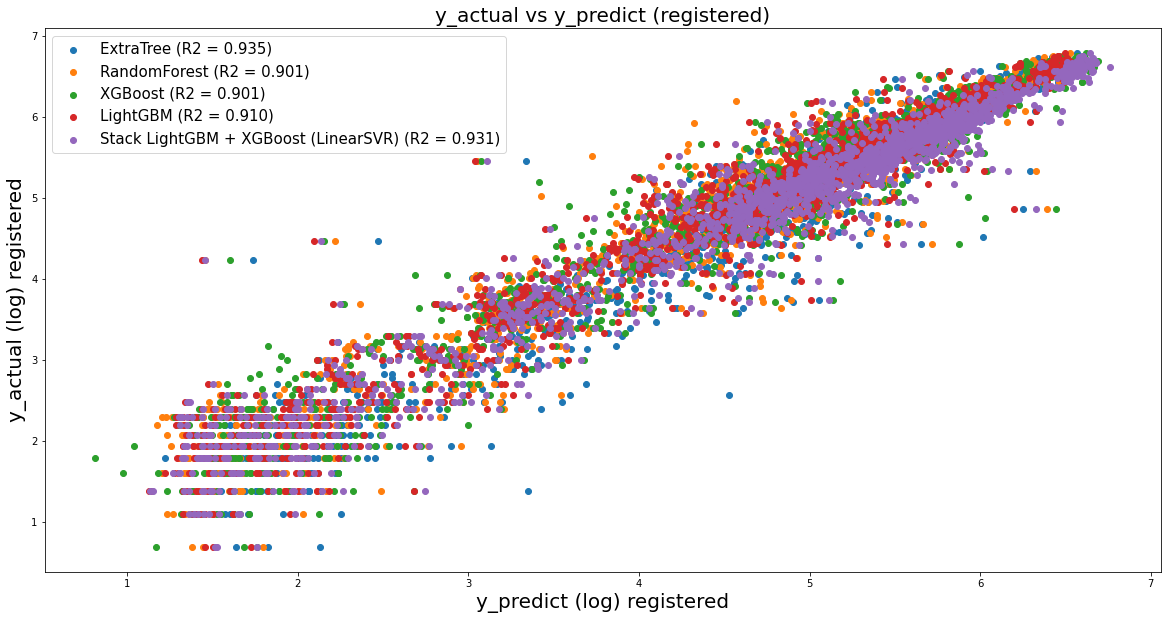

In [47]:
plt.rcParams["figure.figsize"] = (20,10)

plt.scatter(plot_model_registered['y_pred_etr_registered'], plot_model_registered['y_test_registered'],label="ExtraTree (R2 = %0.3f)" % score_etr_registered)
plt.scatter(plot_model_registered['y_pred_rfr_registered'], plot_model_registered['y_test_registered'],label="RandomForest (R2 = %0.3f)" % score_rfr_registered)
plt.scatter(plot_model_registered['y_pred_xgbr_registered'], plot_model_registered['y_test_registered'],label="XGBoost (R2 = %0.3f)" % score_xgbr_registered)
plt.scatter(plot_model_registered['y_pred_lgbm_registered'], plot_model_registered['y_test_registered'],label="LightGBM (R2 = %0.3f)" % score_lgbm_registered)
plt.scatter(plot_model_registered['y_pred_stack_LinearSVR_lgbm_xgboost_registered'], plot_model_registered['y_test_registered'],label="Stack LightGBM + XGBoost (LinearSVR) (R2 = %0.3f)" % score_stack_LinearSVR_lgbm_xgboost_registered)
plt.title('y_actual vs y_predict (registered)', fontsize=20)
plt.xlabel('y_predict (log) registered', fontsize=20)
plt.ylabel('y_actual (log) registered', fontsize=20)
plt.legend(fontsize=15)

In [48]:
model_stack_LinearSVR_lgbm_xgboost_casual.fit(df_final_X, df_final_y_casual)
model_stack_LinearSVR_lgbm_xgboost_registered.fit(df_final_X, df_final_y_registered)

C:\Users\Apprenant\anaconda3\envs\candiapp\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Apprenant\anaconda3\envs\candiapp\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


StackingRegressor(estimators=[('lgbm',
                               Pipeline(steps=[('columntransformer',
                                                ColumnTransformer(transformers=[('pipeline-1',
                                                                                 Pipeline(steps=[('onehotencoder',
                                                                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                                                                 ['holiday',
                                                                                  'workingday',
                                                                                  'season',
                                                                                  'month',
                                                                                  'day',
                                                                                

In [49]:
# pickle.dump(model_stack_LinearSVR_lgbm_xgboost_casual, open('model_stack_LinearSVR_lgbm_xgboost_casual.sav', 'wb'))
# pickle.dump(model_stack_LinearSVR_lgbm_xgboost_registered, open('model_stack_LinearSVR_lgbm_xgboost_registered.sav', 'wb'))
